In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, Reshape, Embedding, GlobalAveragePooling1D, Lambda

2025-05-01 18:19:27.745871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def read_csv_head(input_file, num_lines):
    """
    ƒê·ªçc num_lines d√≤ng ƒë·∫ßu ti√™n t·ª´ file CSV (k·ªÉ c·∫£ d√≤ng header) v√† tr·∫£ v·ªÅ d∆∞·ªõi d·∫°ng list.
    
    :param input_file: ƒê∆∞·ªùng d·∫´n file CSV.
    :param num_lines: S·ªë d√≤ng mu·ªën l·∫•y (bao g·ªìm header).
    :return: Danh s√°ch c√°c d√≤ng ƒë√£ l·∫•y.
    """
    result = []
    with open(input_file, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for i, row in enumerate(reader):
            if i >= num_lines:
                break
            result.append(row)
    return result

In [3]:
data_namp = read_csv_head(r'/mnt/nvme1/nAMP_GenBank.csv', 1150001)  # 1 d√≤ng ti√™u ƒë·ªÅ + 2500 d√≤ng d·ªØ li·ªáu
data_namp = pd.DataFrame(data_namp[1:], columns=data_namp[0])
# data_namp

In [4]:
# data_amp = pd.read_csv(r'/mnt/nvme1/AMP_GenBank.csv')
data_amp = pd.read_csv(r'/mnt/nvme1/AMP_GenBank.csv')  # 1 d√≤ng ti√™u ƒë·ªÅ + 2500 d√≤ng d·ªØ li·ªáu
# data_amp
# data_amp = read_csv_head(r'/mnt/nvme1/AMP_GenBank.csv', 600000)  # 1 d√≤ng ti√™u ƒë·ªÅ + 2500 d√≤ng d·ªØ li·ªáu
# data_amp = pd.DataFrame(data_amp[1:], columns=data_amp[0])

In [5]:
combinated_data = pd.concat([data_namp, data_amp], ignore_index=True)
# data

In [6]:
data, data_test = train_test_split(combinated_data, test_size=0.3, stratify=combinated_data['Label'], random_state=42, shuffle=True)

In [7]:
# data1 = pd.read_csv("input/features.csv")
# data1

In [8]:
# data2 = pd.read_csv("input/features5.csv")
# data2

In [9]:
# data = pd.concat([data1, data2], ignore_index=True)
# data

In [10]:
# data_test = pd.read_csv("input/features_test.csv")
# data_test

### C·ªôt "ID" c√≥ th·ªÉ ch·ªâ l√† m·ªôt ƒë·ªãnh danh duy nh·∫•t cho t·ª´ng d√≤ng, kh√¥ng mang √Ω nghƒ©a ƒë·∫∑c bi·ªát trong m√¥ h√¨nh.

In [11]:
data = data.drop(columns=['ID'])
data_test = data_test.drop(columns=['ID'])

In [12]:
# data.info()

In [13]:
# data_test.info()

### Ki·ªÉm tra v√† x√≥a s·ªë l∆∞·ª£ng rows tr√πng l·∫∑p

In [14]:
# data.duplicated().sum()

In [15]:
# data_test.duplicated().sum()

In [16]:
# data = data.drop_duplicates()
# data_test = data_test.drop_duplicates()

In [17]:
# data.duplicated().sum()

In [18]:
# data_test.duplicated().sum()

### Ki·ªÉm tra xem c√≥ c·ªôt n√†o ch·ª©a gi√° tr·ªã NaN (khuy·∫øt thi·∫øu) hay kh√¥ng.

In [19]:
# null_columns_1 = data.columns[data.isnull().sum() > 0]
# print(data[null_columns_1].isnull().sum())

# null_columns_2 = data_test.columns[data_test.isnull().sum() > 0]
# print(data[null_columns_2].isnull().sum())

### Ph√¢n lo·∫°i c√°c c·ªôt theo ki·ªÉu d·ªØ li·ªáu
#### - float_columns: Ch·ª©a c√°c c·ªôt c√≥ ki·ªÉu d·ªØ li·ªáu float64 (bi·∫øn s·ªë h·ªçc).
#### - object_columns: Ch·ª©a c√°c c·ªôt c√≥ ki·ªÉu d·ªØ li·ªáu object (bi·∫øn d·∫°ng chu·ªói).

In [20]:
float_columns = data.select_dtypes(include=['float64']).columns
object_columns = data.select_dtypes(include=['object']).columns

### D·ªØ li·ªáu c√≥ 2 c·ªôt d·∫°ng chu·ªói:
#### - Label: C√≥ th·ªÉ l√† nh√£n ph√¢n lo·∫°i (v√≠ d·ª•: Antimicrobial vs Non-Antimicrobial ho·∫∑c 1 vs 0).
#### - Sequence: Chu·ªói peptide c·∫ßn d·ª± ƒëo√°n.

In [21]:
# object_columns

### Chuy·ªÉn ƒë·ªïi nh√£n (Label) t·ª´ chu·ªói sang s·ªë (0/1):
#### - N·∫øu Label == 'nAMP' ‚Üí g√°n 0 (Kh√¥ng kh√°ng khu·∫©n).
#### - N·∫øu kh√¥ng ph·∫£i 'nAMP' ‚Üí g√°n 1 (Kh√°ng khu·∫©n).
### Chuy·ªÉn ƒë·ªïi ki·ªÉu d·ªØ li·ªáu th√†nh float ƒë·ªÉ ph√π h·ª£p v·ªõi m√¥ h√¨nh.

In [22]:
data.loc[:, 'Label'] = data['Label'].apply(lambda x: 0 if x == 'nAMP' else 1)
data['Label'] = data['Label'].astype(float)

data_test.loc[:, 'Label'] = data_test['Label'].apply(lambda x: 0 if x == 'nAMP' else 1)
data_test['Label'] = data_test['Label'].astype(float)

# data

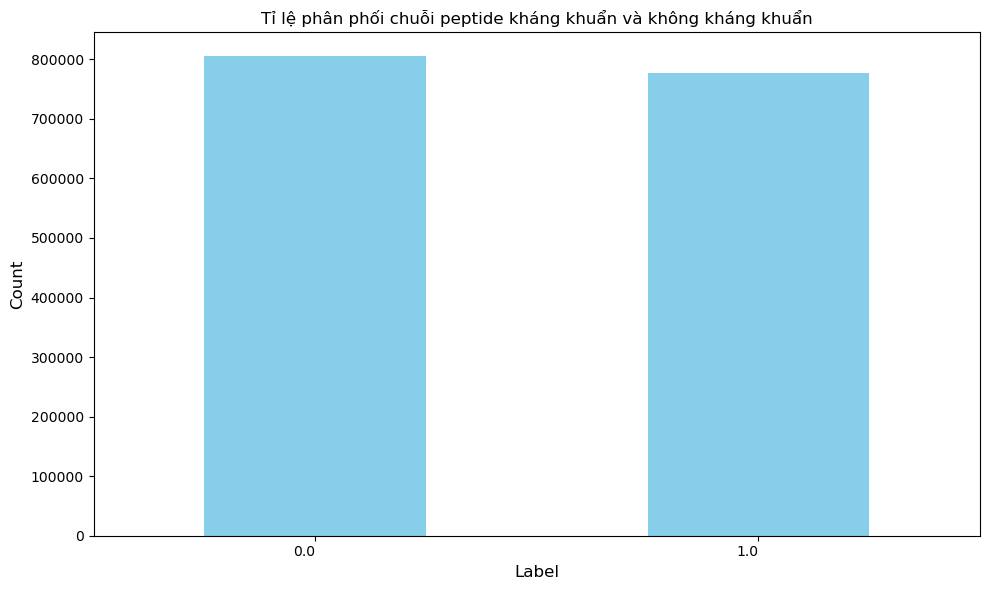

In [23]:
label_counts = data['Label'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color = 'skyblue')
plt.title('T·ªâ l·ªá ph√¢n ph·ªëi chu·ªói peptide kh√°ng khu·∫©n v√† kh√¥ng kh√°ng khu·∫©n')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [24]:
x_test = data_test.drop(columns=['Label'])
y_test = data_test['Label']

X_train = data.drop(columns=['Label'])
y_train = data['Label']

### Ki·ªÉm tra (m·∫´u, ƒë·∫∑c tr∆∞ng)

In [25]:
# print(x_test.shape)
# print(y_test.shape)

# print(X_train.shape)
# print(y_train.shape)

In [26]:
X_val, X_test, Y_val, Y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=42, shuffle=True)

### chu·ªói sequence d·∫°ng ch·ªØ, chuy·ªÉn v·ªÅ chu·ªói s·ªë

In [27]:
# sequence_lengths = [len(seq) for seq in  data['Sequence']]  

# # T√≠nh gi√° tr·ªã percentile 95%
# max_length = int(np.percentile(sequence_lengths, 95))  
# print(f"Max length h·ª£p l√Ω d·ª±a tr√™n 95% d·ªØ li·ªáu: {max_length}")

### ƒê·ªám ho·∫∑c c·∫Øt ·ªü ph√≠a sau
###  L√Ω do ch·ªçn 'post':
#### - Gi·ªØ th√¥ng tin quan tr·ªçng ·ªü ƒë·∫ßu chu·ªói, v√¨ ƒë·∫ßu peptide c√≥ th·ªÉ ch·ª©a th√¥ng tin quan tr·ªçng v·ªÅ t√≠nh kh√°ng khu·∫©n.

In [28]:
# pip install tensorflow

In [29]:
max_length = 50

padding_type = 'post' # ƒê·ªám th√™m s·ªë 0
trunc_type = 'post'  # C·∫Øt n·∫øu chu·ªói d√†i

In [30]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data['Sequence'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  26


In [31]:
tokenizer.word_index

{'r': 1,
 'l': 2,
 'a': 3,
 'k': 4,
 'g': 5,
 'v': 6,
 's': 7,
 't': 8,
 'i': 9,
 'p': 10,
 'q': 11,
 'f': 12,
 'n': 13,
 'e': 14,
 'y': 15,
 'd': 16,
 'm': 17,
 'h': 18,
 'w': 19,
 'c': 20,
 'x': 21,
 'j': 22,
 'b': 23,
 'z': 24,
 'u': 25}

In [32]:
train_sequences  = tokenizer.texts_to_sequences(X_train['Sequence'])
train_sequence_array = pad_sequences(train_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val['Sequence'])
val_sequence_array = pad_sequences(val_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test['Sequence'])
test_sequence_array = pad_sequences(test_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

In [33]:
X_train= X_train.drop(columns=['Sequence'])
X_train['train_sequences'] = train_sequence_array.tolist()

X_val= X_val.drop(columns=['Sequence'])
X_val['val_sequences'] = val_sequence_array.tolist()

X_test= X_test.drop(columns=['Sequence'])
X_test['test_sequences'] = test_sequence_array.tolist()

In [34]:
# X_train.describe()

In [35]:
# columns_with_max_equal_1 = X_train.columns[X_train.max() == 1]
# columns_with_min_equal_0 = X_train.columns[X_train.min() == 0]

# # In k·∫øt qu·∫£
# print("C√°c c·ªôt c√≥ max == 1:", len(list(columns_with_max_equal_1)))
# print("C√°c c·ªôt c√≥ min == 0:", len(list(columns_with_min_equal_0)))

## Ki·ªÉm tra X_train
#### T·ªïng c√≥ 127 c·ªôt. T√°ch th√†nh 126 + 1 c·ªôt m·∫£ng

In [36]:
# print(X_train.dtypes.value_counts())

In [37]:
X_train_num = X_train.iloc[:, :126]  # Ch·ªçn 126 c·ªôt ƒë·∫ßu ti√™n
X_train_text = X_train.iloc[:, -1]   # Ch·ªçn c·ªôt cu·ªëi c√πng

In [38]:
# object_cols = X_train.select_dtypes(include=['object']).columns
# print("C·ªôt object:", object_cols)

In [39]:
# print(X_train_text.head(10))  # Xem 10 d√≤ng ƒë·∫ßu

## Ki·ªÉm tra X_val
#### T·ªïng c√≥ 127 c·ªôt. T√°ch th√†nh 126 + 1 c·ªôt m·∫£ng

In [40]:
# print(X_val.dtypes.value_counts())

In [41]:
X_val_num = X_val.iloc[:, :126]  # Ch·ªçn 126 c·ªôt ƒë·∫ßu ti√™n
X_val_text = X_val.iloc[:, -1]   # Ch·ªçn c·ªôt cu·ªëi c√πng

In [42]:
# print(X_val_text.head(10))  # Xem 10 d√≤ng ƒë·∫ßu

## Ki·ªÉm tra d·ªØ li·ªáu hu·∫•n luy·ªán
In th·ª≠ m·ªôt v√†i gi√° tr·ªã trong X_train v√† X_val ƒë·ªÉ ki·ªÉm tra xem c√≥ gi√° tr·ªã √¢m ho·∫∑c kh√¥ng h·ª£p l·ªá kh√¥ng

In [43]:
# print(f"X_train_text - NaN: {pd.isna(X_train_text).sum()} / Total: {X_train_text.size}")
# print(f"X_val_text - NaN: {pd.isna(X_val_text).sum()} / Total: {X_val_text.size}")

In [44]:
# X_train_num = np.array(X_train_num, dtype=np.float32)
# X_val_num = np.array(X_val_num, dtype=np.float32)
X_train_num = X_train_num.to_numpy(dtype=np.float32)
X_val_num = X_val_num.to_numpy(dtype=np.float32)

In [45]:
# ƒê·ªãnh nghƒ©a ƒë·ªô d√†i c·ªë ƒë·ªãnh cho X_train_text v√† X_val_text
max_len = max_length  

# Chuy·ªÉn ƒë·ªïi t·∫•t c·∫£ th√†nh danh s√°ch c√πng k√≠ch th∆∞·ªõc
X_train_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_train_text], dtype=np.int32)

X_val_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_val_text], dtype=np.int32)

print("X_train_text shape:", X_train_text.shape)
print("X_val_text shape:", X_val_text.shape)

X_train_text shape: (1581599, 50)
X_val_text shape: (338914, 50)


### C√°c class hu·∫•n luy·ªán model
#### - ƒêi·ªÅu ki·ªán quan tr·ªçng: embed_dim ph·∫£i chia h·∫øt cho heads ƒë·ªÉ m·ªói ƒë·∫ßu Attention c√≥ k√≠ch th∆∞·ªõc vector b·∫±ng nhau.
#### - Th√¥ng th∆∞·ªùng, s·ªë neurons trong FFN (neurons) n√™n g·∫•p 2-4 l·∫ßn embed_dim ƒë·ªÉ m√¥ h√¨nh c√≥ ƒë·ªß kh·∫£ nƒÉng tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng.
#### - G·ª£i √Ω c√¥ng th·ª©c: neurons = 2 √ó embed_dim ho·∫∑c neurons = 4 √ó embed_dim.

In [46]:
# ƒê·ªãnh nghƒ©a Transformer Encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim // heads) # NOTE
        self.ffn = tf.keras.Sequential([
            layers.Dense(neurons, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.2)
        self.dropout2 = layers.Dropout(0.2)

    def call(self, inputs, training=None, mask=None):
        if mask is not None:
            # MHA y√™u c·∫ßu mask shape: (batch_size, 1, 1, seq_len) ho·∫∑c (batch_size, seq_len)
            mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)  # (batch_size, 1, seq_len)
    
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# L·ªõp embedding cho chu·ªói vƒÉn b·∫£n
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        x_embed = self.token_emb(x)
        return x_embed + positions, self.token_emb.compute_mask(x)


class MultiLayerTransformerEncoder(layers.Layer):
    def __init__(self, num_layers, embed_dim, heads, neurons):
        super(MultiLayerTransformerEncoder, self).__init__()
        self.encoders = [
            TransformerEncoder(embed_dim, heads, neurons)
            for _ in range(num_layers)
        ]

    def call(self, x, mask=None, training=False):
        for encoder_layer in self.encoders:
            x = encoder_layer(x, training=training, mask=mask)

        return x

In [47]:
# ==== THAM S·ªê ====
# ƒê·∫£m b·∫£o TensorFlow ƒëang ch·∫°y trong Eager Execution

embed_dim = 200   # K√≠ch th∆∞·ªõc vector embedding
heads = 6        # S·ªë ƒë·∫ßu attention
neurons = 400     # S·ªë n∆°-ron c·ªßa l·ªõp fully connected
maxlen = 50      # Chi·ªÅu d√†i chu·ªói ƒë·∫ßu v√†o (thay max_length b·∫±ng 100)
num_features = 126  # S·ªë l∆∞·ª£ng c·ªôt s·ªë ƒë·∫ßu v√†o
vocab_size = vocab_size   # K√≠ch th∆∞·ªõc t·ª´ v·ª±ng
num_layers = 4    # S·ªë l·ªõp transformer encoder

# ==== ƒê·ªäNH NGHƒ®A INPUT ====
# Input cho d·ªØ li·ªáu s·ªë
num_input = Input(shape=(num_features,))
num_reshaped = Dense(embed_dim, activation="relu")(num_input)
num_reshaped = Reshape((1, embed_dim))(num_reshaped)  # Shape: (batch_size, 1, embed_dim)

# Input vƒÉn b·∫£n
text_input = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
text_embedded, text_mask = embedding_layer(text_input)  # Shape: (batch_size, maxlen, embed_dim), (batch_size, maxlen)

# Gh√©p 2 ƒë·∫ßu v√†o: (1 + maxlen, embed_dim)
merged_input = Concatenate(axis=1)([num_reshaped, text_embedded])

# Gh√©p mask: num_input kh√¥ng ph·∫£i padding ‚Üí mask = 1
def create_combined_mask(text_mask):
    # T·∫°o mask cho d·ªØ li·ªáu s·ªë (num_input) v·ªõi gi√° tr·ªã l√† 1
    num_mask = tf.ones_like(text_mask[:, :1], dtype=tf.int32)  # num_mask s·∫Ω c√≥ ki·ªÉu int32
    text_mask = tf.cast(text_mask, dtype=tf.int32)  # Chuy·ªÉn text_mask sang ki·ªÉu int32
    return tf.concat([num_mask, text_mask], axis=1)


merged_mask = Lambda(
    create_combined_mask,
    output_shape=(maxlen + 1,)
)(text_mask)

# N·∫øu c·∫ßn, reshape th√™m cho ph√π h·ª£p v·ªõi attention mask y√™u c·∫ßu
merged_mask = Lambda(lambda x: tf.cast(tf.expand_dims(x, axis=1), tf.float32))(merged_mask)

# Transformer encoder
multi_encoder = MultiLayerTransformerEncoder(num_layers=num_layers, embed_dim=embed_dim, heads=heads, neurons=neurons)
x = multi_encoder(merged_input, mask=merged_mask)

# Global Average Pooling ƒë·ªÉ gi·∫£m chi·ªÅu d·ªØ li·ªáu
x = GlobalAveragePooling1D()(x)

# Fully connected layers
x = Dense(neurons, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(embed_dim, activation="relu")(x)
x = Dropout(0.2)(x)

# Output (v√≠ d·ª•: classification v·ªõi softmax, c√≥ th·ªÉ thay ƒë·ªïi)
output = Dense(1, activation="sigmoid")(x)

2025-05-01 18:25:30.925965: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-05-01 18:25:30.942155: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-05-01 18:25:31.115147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-01 18:25:31.118420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.58GiB deviceMemoryBandwidth: 298.08GiB/s
2025-05-01 18:25:31.118486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-05-01 18:25:31.203677: I tensorflow/stream_executor/platform/default/dso_loade

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [48]:
# ==== T·∫†O M√î H√åNH ====
model = Model(inputs=[num_input, text_input], outputs=output)

optimizer = Adam(learning_rate=0.000000005)  # Gi·∫£m t·ªëc ƒë·ªô h·ªçc th√™m
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Hi·ªÉn th·ªã m√¥ h√¨nh
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 126)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          25400       input_1[0][0]                    
__________________________________________________________________________________________________
token_and_position_embedding (T ((None, 50, 200), (N 15200       input_2[0][0]                    
______________________________________________________________________________________________

In [49]:
# model.load_weights('GenBank_transfomer_peptide_weights.best.weights.h5')

In [50]:
weight_path = "{}_weights.best.weights.h5".format('VS2_GenBank_transfomer_peptide')
# weight_path = "{}_weights.best.weights.h5".format('hyper_param')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

reduce = ReduceLROnPlateau(
        monitor="val_loss", factor=0.1,
        patience=2, verbose=1
    )

callbacks_list = [checkpoint, early, reduce]

In [51]:
history = model.fit(
    [X_train_num, X_train_text], y_train,  # ƒê·∫ßu v√†o g·ªìm d·ªØ li·ªáu s·ªë v√† d·ªØ li·ªáu chu·ªói
    validation_data=([X_val_num, X_val_text], Y_val),  # Validation c≈©ng c√≥ hai ƒë·∫ßu v√†o
    epochs=200,
    batch_size=32,
    callbacks=callbacks_list  # D√πng danh s√°ch callbacks ƒë√£ khai b√°o ·ªü cell 1
) 

2025-05-01 18:25:34.899142: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 797125896 exceeds 10% of free system memory.
2025-05-01 18:25:35.487178: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 316319800 exceeds 10% of free system memory.
2025-05-01 18:25:35.772033: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-05-01 18:25:35.780833: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/200


2025-05-01 18:25:38.782049: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


49425/49425 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.5579      

2025-05-01 18:37:42.344200: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 170812656 exceeds 10% of free system memory.


49425/49425 [==============================] - 786s 16ms/step - loss: 0.6837 - accuracy: 0.5579 - val_loss: 0.6261 - val_accuracy: 0.6943

Epoch 00001: val_loss improved from inf to 0.62610, saving model to VS2_GenBank_transfomer_peptide_weights.best.weights.h5
Epoch 2/200
49425/49425 [==============================] - 788s 16ms/step - loss: 0.6436 - accuracy: 0.6469 - val_loss: 0.5798 - val_accuracy: 0.7519

Epoch 00002: val_loss improved from 0.62610 to 0.57980, saving model to VS2_GenBank_transfomer_peptide_weights.best.weights.h5
Epoch 3/200
49425/49425 [==============================] - 788s 16ms/step - loss: 0.6050 - accuracy: 0.7185 - val_loss: 0.5302 - val_accuracy: 0.7967

Epoch 00003: val_loss improved from 0.57980 to 0.53024, saving model to VS2_GenBank_transfomer_peptide_weights.best.weights.h5
Epoch 4/200
49425/49425 [==============================] - 791s 16ms/step - loss: 0.5634 - accuracy: 0.7775 - val_loss: 0.4771 - val_accuracy: 0.8246

Epoch 00004: val_loss improved 

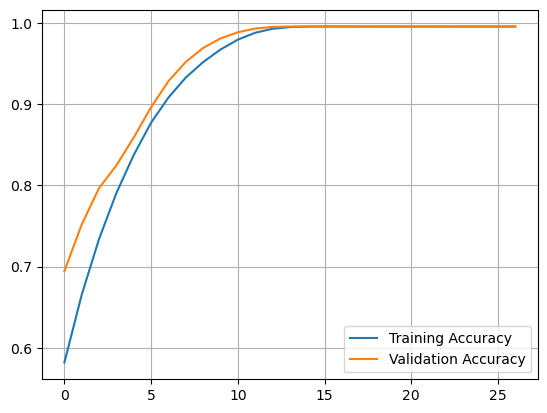

In [52]:
def plot_history_accuracy(history):
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_accuracy(history=history)

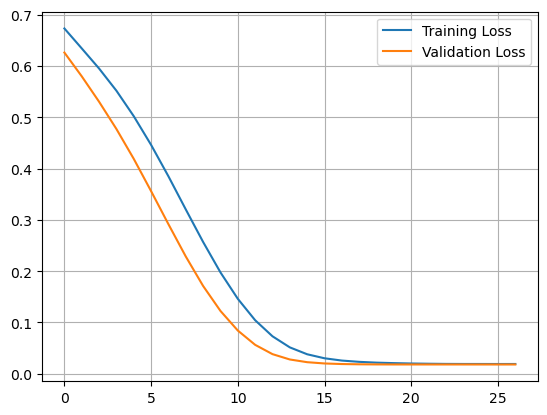

In [53]:
def plot_history_loss(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_loss(history=history)

In [54]:
X_test_num = X_test.iloc[:, :126]  # Ch·ªçn 126 c·ªôt ƒë·∫ßu ti√™n
X_test_text = X_test.iloc[:, -1]   # Ch·ªçn c·ªôt cu·ªëi c√πng

# X_test_num = np.array(X_test_num, dtype=np.float32)
X_test_num = X_test_num.to_numpy(dtype=np.float32)

In [55]:
# ƒê·ªãnh nghƒ©a ƒë·ªô d√†i c·ªë ƒë·ªãnh cho X_train_text v√† X_val_text
max_len = max_length

# Chuy·ªÉn ƒë·ªïi t·∫•t c·∫£ th√†nh danh s√°ch c√πng k√≠ch th∆∞·ªõc
# X_test_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_test_text], dtype=np.int32)
X_test_text = test_sequence_array

print("X_train_text shape:", X_test_text.shape)

X_train_text shape: (338915, 50)


In [56]:
predictions = model.predict([X_test_num, X_test_text],verbose = True)
predictions = (predictions >= 0.5).astype(int)

2025-05-02 01:28:17.173449: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 170813160 exceeds 10% of free system memory.


10592/10592 [==============================] - 57s 5ms/step


In [57]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(Y_test, predictions, target_names=['nAMP (Class 0)', 'AMP (Class 1)']))

                precision    recall  f1-score   support

nAMP (Class 0)       1.00      0.99      1.00    172500
 AMP (Class 1)       0.99      1.00      1.00    166415

      accuracy                           1.00    338915
     macro avg       1.00      1.00      1.00    338915
  weighted avg       1.00      1.00      1.00    338915



In [58]:
cm = confusion_matrix(Y_test, predictions)
cm = pd.DataFrame(cm, index=['nAMP', 'AMP'], columns=['nAMP', 'AMP'])

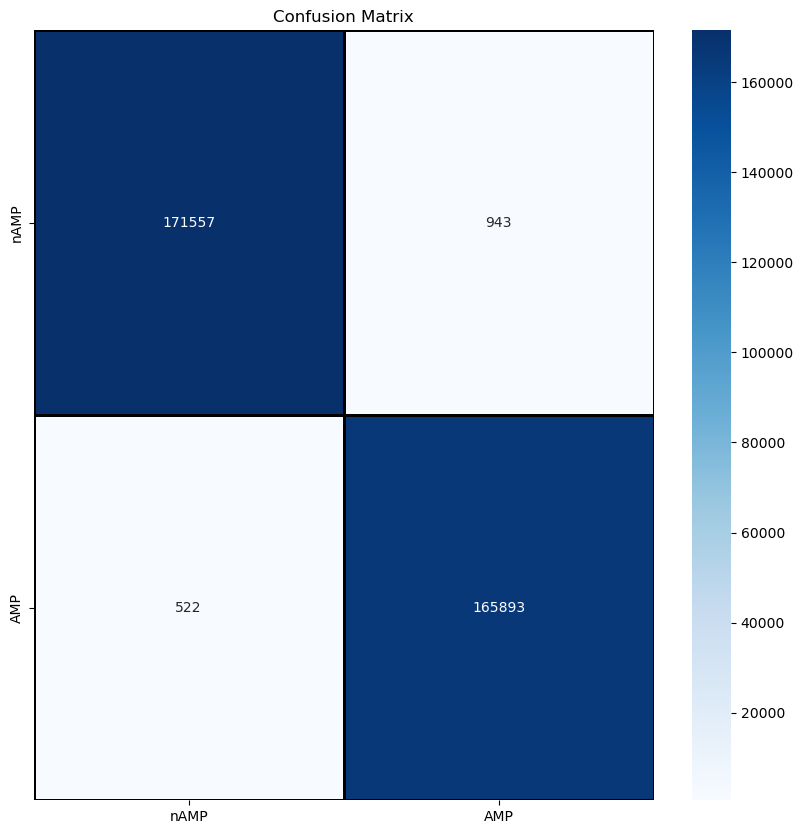

In [59]:
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='d', xticklabels=cm.columns, yticklabels=cm.index)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# model.load_weights('transfomer_peptide_weights.best.weights.h5')

In [60]:
X_test_num = X_test.iloc[:, :126]  # Ch·ªçn 126 c·ªôt ƒë·∫ßu ti√™n
X_test_text = X_test.iloc[:, -1]   # Ch·ªçn c·ªôt cu·ªëi c√πng

X_test_num = np.array(X_test_num, dtype=np.float32)

# ƒê·ªãnh nghƒ©a ƒë·ªô d√†i c·ªë ƒë·ªãnh cho X_train_text v√† X_val_text
max_len = 50  

# Chuy·ªÉn ƒë·ªïi t·∫•t c·∫£ th√†nh danh s√°ch c√πng k√≠ch th∆∞·ªõc
X_test_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_test_text], dtype=np.int32)

In [61]:
num_features = X_train_num.shape[1]
text_features = X_train_text.shape[1]

def predict_proba_lime(X):
    X_num = X[:, 0:num_features]
    X_text = X[:, num_features:(num_features + text_features)] 
 
    # D·ª± ƒëo√°n t·ª´ m√¥ h√¨nh
    probs = model.predict([X_num, X_text])  
    
    print(f"Tr∆∞·ªõc khi flatten {probs.shape}")
    probs = probs.flatten()  # Chuy·ªÉn th√†nh m·∫£ng m·ªôt chi·ªÅu
    print(f"Sau khi flatten {probs.shape}")

    # X√°c su·∫•t cho class 0 v√† class 1
    probs_class_0 = 1 - probs  
    probs_class_1 = probs   
    print(f"probs_class_0 {probs_class_0.shape}")
    print(f"probs_class_1 {probs_class_1.shape}")

    result = np.hstack([probs_class_0[:, np.newaxis], probs_class_1[:, np.newaxis]])
    print(result)
    print(f"result {result.shape}")
    
    # Tr·∫£ v·ªÅ m·∫£ng 2 chi·ªÅu v·ªõi x√°c su·∫•t c·ªßa c·∫£ hai l·ªõp
    return result# class 0, class 1

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

class_names = ['nAMP', 'AMP']

feature_names = data1.drop(columns=['ID', 'Label', 'Sequence']).columns.tolist()
text_feature_names = [f"num_feat_{i}" for i in range(X_train_text.shape[1])]
full_feature_names = feature_names + text_feature_names

X_train_combined = np.concatenate([X_train_num, X_train_text], axis=1)
    
explainer = LimeTabularExplainer(X_train_combined, feature_names =     
                                 full_feature_names,
                                 class_names = class_names, 
                                 mode = 'classification')

In [ ]:
sample_num = X_test_num[10]
sample_text = X_test_text[10]
sample = np.concatenate([sample_num, sample_text])

In [ ]:
exp = explainer.explain_instance(
    data_row=sample, 
    predict_fn=predict_proba_lime
)

exp.show_in_notebook(show_table=True)
exp.save_to_file('lime_explanation1.html')

In [ ]:
sample_num = X_test_num[11]
sample_text = X_test_text[11]
sample = np.concatenate([sample_num, sample_text])

In [ ]:
exp = explainer.explain_instance(
    data_row=sample, 
    predict_fn=predict_proba_lime
)

exp.show_in_notebook(show_table=True)
exp.save_to_file('lime_explanation2.html')

## Convert html th√†nh png ƒë·ªÉ post l√™n git

In [14]:
# !pip install selenium pillow

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from PIL import Image as PILImage
from IPython.display import Image, display
import time
import os

def save_lime_html_to_png(filename_base):
    """
    Convert a LIME explanation HTML file to PNG image and display it in notebook.
    
    :param filename_base: T√™n file kh√¥ng ƒëu√¥i (ho·∫∑c c√≥ ƒëu√¥i .html) c·ªßa file HTML LIME ƒë√£ l∆∞u
    """
    # ‚ûï Th√™m .html n·∫øu ch∆∞a c√≥
    if not filename_base.endswith('.html'):
        filename_base += '.html'
    
    # üìç Path ƒë·∫øn file HTML
    html_file = os.path.abspath(filename_base)

    # ‚öôÔ∏è Setup headless Chrome
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--window-size=1200,800')

    try:
        driver = webdriver.Chrome(options=options)

        # üñºÔ∏è Load file HTML
        driver.get('file://' + html_file)
        time.sleep(2)  # ƒë·ª£i HTML render

        # üì∏ Ch·ª•p m√†n h√¨nh v√† l∆∞u
        output_file = filename_base.replace('.html', '.png')
        driver.save_screenshot(output_file)
        driver.quit()

        # ‚úÖ Hi·ªÉn th·ªã ·∫£nh trong notebook
        display(Image(filename=output_file))

    except Exception as e:
        print("‚ùå L·ªói khi ch·ª•p HTML:", e)


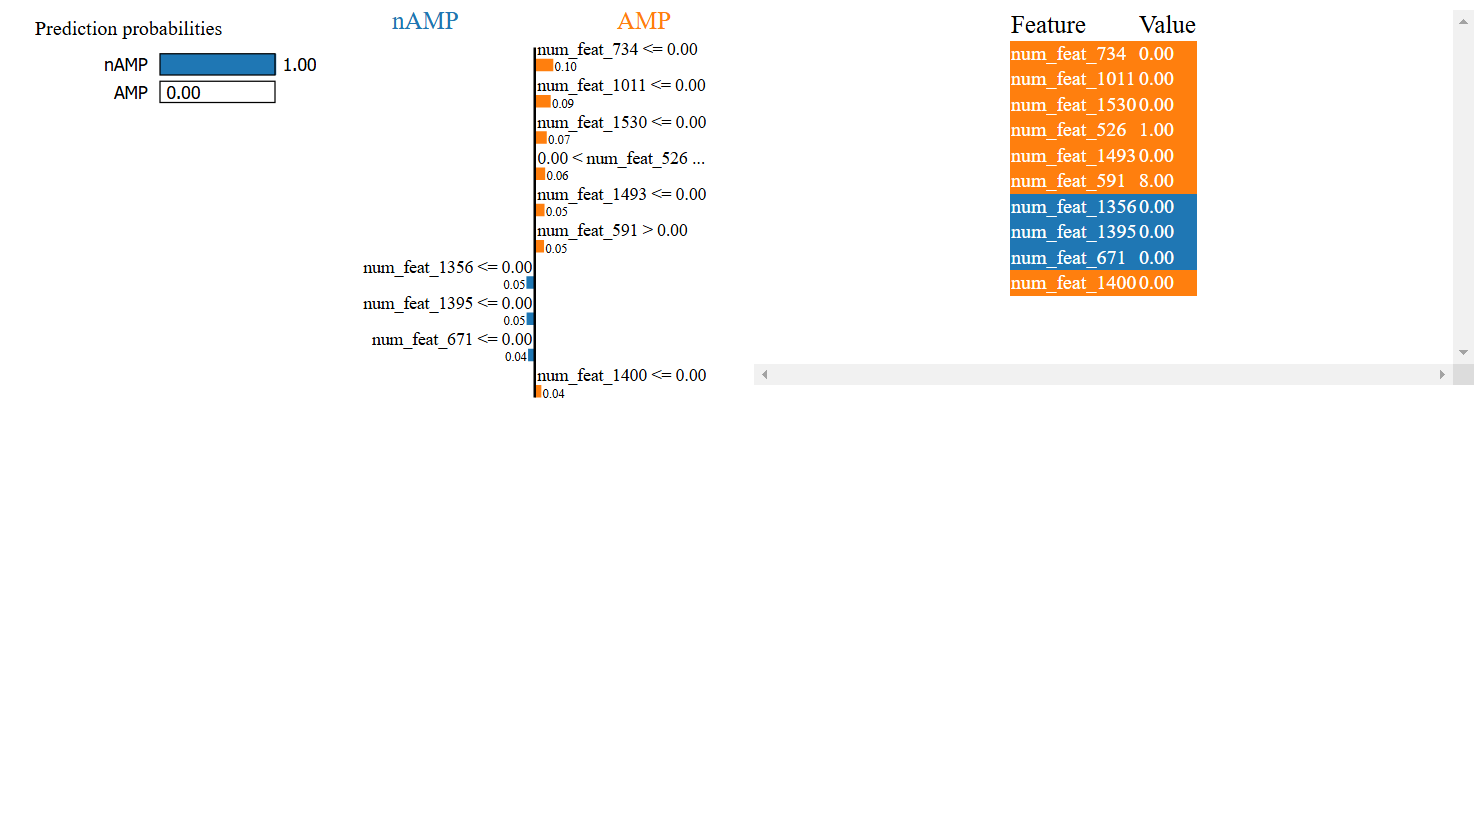

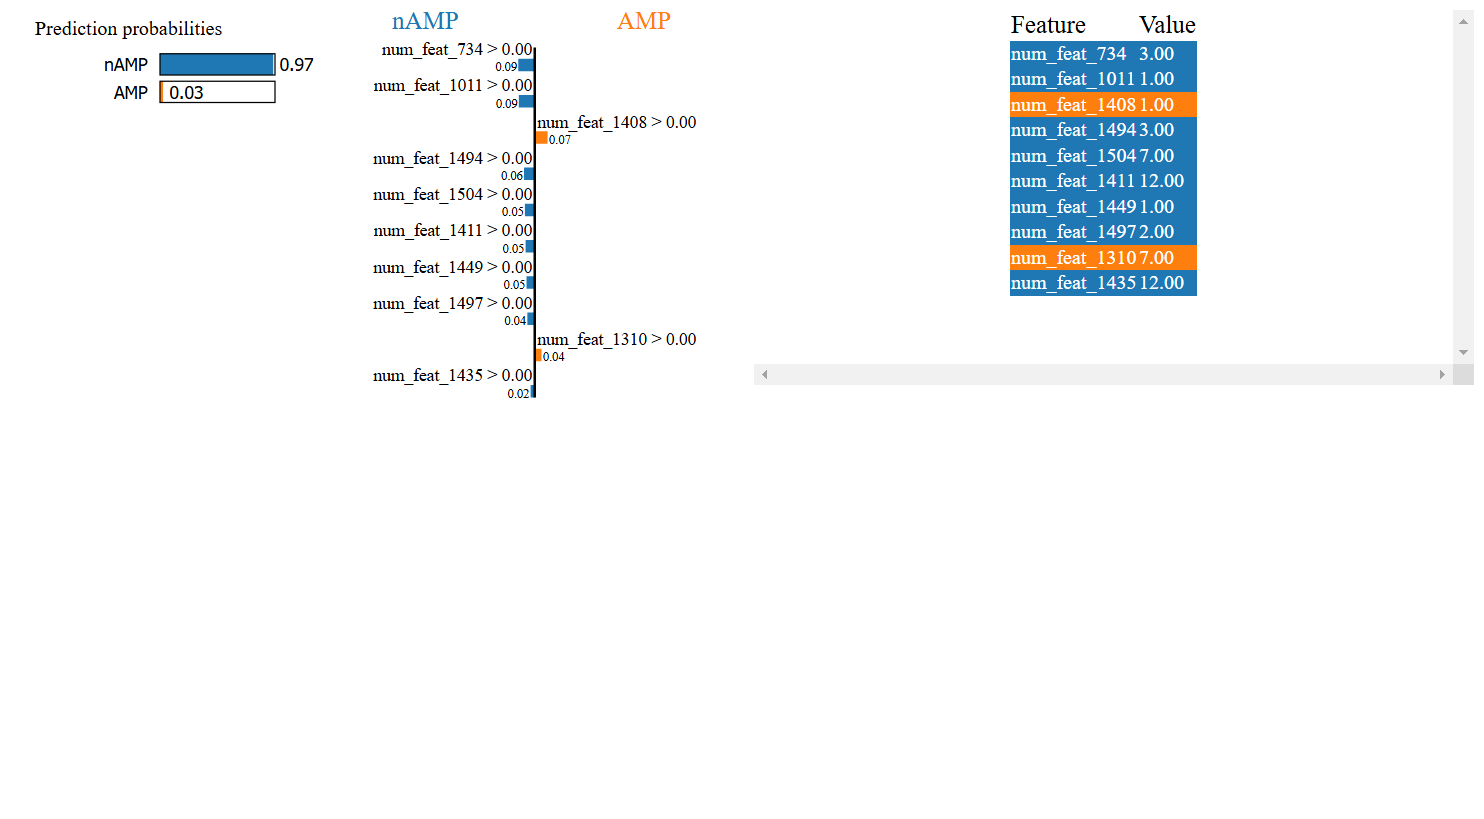

In [15]:
save_lime_html_to_png('lime_explanation1')
save_lime_html_to_png('lime_explanation2')